# Progressive simulation analysis: notebook to generate and analyze data

The first part of this notebook is about validating the heuristic probability distribution in our paper [Boundaries for quantum advantage with single photons and loop-based time-bin interferometers](https://arxiv.org/abs/2411.16873). We first invoke a shell utility used to automatically generate a large number of simulated data from several different architectures and setups. We will generate samples for the same architectures twice, once using the real probability distribution (i.e. running the progressive simulator), and second time using the heuristic, so that they can be compared. For the purpose of the notebook, we only generate a small sample of the data. Then we draw a validation plot similar to the one in the paper.

The second part of the notebook is about analyzing the memory complexity of power-law loop-based systems as a function of the number of modes, and of the loop base lengths, as studied in the paper. Again, we will generate data, this time only using our validated heuristic, so that we do not need to run the expensive simulation. This way, we can estimate the memory required for many different architectures, even those that are too complex to simulate.

## Technical setup

What follows is technical setup: imports and $\LaTeX$ for plot drawing. This can be safely ignored.

In [2]:
# Built-ins
import sys
import os
import subprocess
from collections import namedtuple
from itertools import chain

# External libraries
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

# Internal library
from data_analysis import separate_meta_files, load_experiments

sys.path.append(os.path.abspath("../loop_progressive_simulator"))
from utils import cpu_count


# LaTeX preamble
PREAMBLE = r"""
\usepackage{amsmath}
\usepackage{stmaryrd}

\renewcommand{\vec}[1]{\underline{#1}}
\newcommand{\ket}[1]{\left| #1 \right\rangle}
\newcommand{\neket}[1]{| #1 \rangle}
\newcommand{\then}{\fatsemi}
"""

# Matplotlib LaTeX setup
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": PREAMBLE,
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'pgf.rcfonts': False,
    "pgf.preamble": PREAMBLE
})

## Experiment setup

Data will be generated using a scheduler that parallelizes several independent runs of the simulation, depending on the available CPUs. By default, all CPUs will be used -- if you want to limit this, set the value of `maximum_cpus` to the desired number. For reference, below is the number of available CPUs:

In [3]:
print(f"You have {cpu_count()} CPUs available.")

You have 8 CPUs available.


Here, set the number of CPUs you want to use. Leave `None` to use all.

In [4]:
maximum_cpus = None

if maximum_cpus is None:
    maximum_cpus = cpu_count()

Similarly, in the interest of time, you can choose to generate fewer samples per experiment (i.e. architecture + simulation parameter setup) by setting the `number_of_samples`.

In [5]:
number_of_samples = 100

print(f"Will use {maximum_cpus} CPUs.\n"
      f"Each experiment will generate {number_of_samples} samples.")

Will use 8 CPUs.
Each experiment will generate 10 samples.


The following is the implementation of memory complexity. The definition is
$$M(\underline n') = \max_t |\mu^t{\downarrow}|,$$
i.e. the maximum memory needed to store the state vector during a run of the simulation that produces the output pattern $\underline n'$. This is computed using the lattice path formalism; however, the computation is already done as part of the sample generation, so here, we just need to extract it from the experiment data.

The argument `fc_log` is a data structure containing all the information about the sample. It's a list whose elements correspond to the progressive components $P_a$; each `component` corresponds to a dictionary with an element `component["fc"]` that stores a sequence $$[|\mu^t{\downarrow}|, |\mu^{t+1}{\downarrow}|, \dots, |\mu^{t'}{\downarrow}|].$$

In [6]:
def memory_complexity(fc_log):
    fcs = chain(*(component["fc"] for component in fc_log))
    return max(fcs)

# Heuristic validation

In this section, we generate data used to validate the heuristic, using the script [./generate_samples_heuristic_validation.sh](./generate_samples_heuristic_validation.sh). This will run the progressive simulation for a choice of architectures, and then use the heuristic to obtain samples from the same architectures. Using this, we then draw a validation plot similar to the one in the paper where we compare the distribution of memory complexity obtained from full simulation, and from the heuristic. The plot may be less precise if you use a lower number of samples.

The data should take about 10 minutes to generate on a laptop with the default settings. Set `number_of_samples` to a lower value to speed this up.

NB: In the paper, we include architectures such as $m = 22$ with $\underline\ell = (1,7,9)$. In the data generation script, these are omitted, because they take a while to generate -- recall that for validation, we need to run the progressive simulation algorithm, i.e. actually simulate these circuits. For that reason, we omit them in this notebook by default.
If you wish to simulate these as well, follow the instructions in [./generate_samples_heuristic_validation.sh](./generate_samples_heuristic_validation.sh) to re-enable them.

In [7]:
subprocess.call(["chmod", "u+x", "./generate_samples_heuristic_validation.sh"])


log_file = "./heuristic-validation.log"
print(f"Starting generation of samples; scheduler log will be saved in {log_file}.\nIndividual logs will be in ./logs.\nExperiment results will be in ./experiments.")
with open(log_file, "wb") as log:
    subprocess.run(["./generate_samples_heuristic_validation.sh", str(maximum_cpus), str(number_of_samples)],
                   stdout = log, stderr = log)
print("==> Done.")

Starting generation of samples; scheduler log will be saved in ./heuristic-validation.log. Individual logs will be in ./logs. Experiment results will be in ./experiments.
==> Done.


## Data analysis

We now analyze the data we generated above. The below data-loading code filters the experiments on their metadata (i.e. choice of architecture and whether to simulate amplitudes, or use lattice paths with the heuristic) and chooses to load those that are relevant to heuristic validation. If you are running this notebook for the first time, you only have experiments that will pass the filter so far -- the filtering ensures you can play with the code, and come back here to regenerate plots later, perhaps with more/different data.

First, we load the real data, i.e. the samples from the real probability distribution obtained from progressive simulation with random angles.

In [21]:
base_path = "./experiments"
separate_meta_files(base_path)


data = load_experiments(
    base_path = base_path,
    # Filter experiment setups on the metadata: we want the experiments that computed amplitudes
    # in contrast to using lattice paths with the heuristic.
    filter_on_meta = lambda meta: (meta["amplitudes"]
                                   and meta["progressive"]
                                   and meta["beamsplitter_angles_random"]
                                   and ("output_state_heuristic" not in meta
                                        or not bool(meta["output_state_heuristic"]))
                                   ),

    # Each instance (individual run) is transformed into a dictionary as below.
    map = lambda inst: {"number_modes": inst["meta"]["number_modes"],
                        "loop_lengths": tuple(inst["meta"]["loop_lengths"]),
                        "fc_log": [{"fc": component["fc@BS"],
                                    "n<M": component["n<M"]}
                                    for component in inst["fc_log"]],
                        },

    # All instances are reduced together to a single dictionary.
    reduce_instances = lambda insts: {"number_modes": insts[0]["number_modes"],
                                      "loop_lengths": insts[0]["loop_lengths"],
                                      "data": np.array([memory_complexity(i["fc_log"]) for i in insts])
                                      },

    # Finally, experiments are all reduced together to a single pd.DataFrame.
    reduce_experiments = lambda exprs: pd.DataFrame([((expr["number_modes"], expr["loop_lengths"]), "real", mem)
                                                        for _eid, expr in exprs.items() for mem in expr["data"]],
                                                    columns=["arch", "probability", "memory"]),

    # Do not show a tqdm progress bar for each experiment.
    tqdm_internal = False)

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

Loaded 3 out of 136 available experiments.


Next, we load the heuristic samples matching the architectures we have above.

In [22]:
# Find unique architectures
data_architectures = set(data["arch"].values)


heur = load_experiments(
    base_path = base_path,

    # Filter: select those experiments that use the heuristic (here called "paths"),
    # such that the architecture is contained in the data above.
    filter_on_meta = lambda meta: ("output_state_heuristic" in meta
                                    and meta["output_state_heuristic"] == "paths"
                                    and (meta["number_modes"], tuple(meta["loop_lengths"])) in data_architectures),
                                    
    map = lambda inst: {"number_modes": inst["meta"]["number_modes"],
                        "loop_lengths": tuple(inst["meta"]["loop_lengths"]),
                        "fc_log": [{"fc": [step["lp"] for step in component["fc@BS"]],
                                    "n<M": component["n<M"]}
                                    for component in inst["fc_log"]],
                        },

    reduce_instances = lambda insts: {"number_modes": insts[0]["number_modes"],
                                      "loop_lengths": insts[0]["loop_lengths"],
                                      "data": np.array([memory_complexity(i["fc_log"]) for i in insts]),
                                     },

    reduce_experiments = lambda exprs: pd.DataFrame([((expr["number_modes"], expr["loop_lengths"]), "heuristic", mem)
                                                        for _eid, expr in exprs.items()
                                                        for mem in expr["data"]],
                                                    columns=["arch", "probability", "memory"]),

    tqdm_internal = False)

  0%|          | 0/136 [00:00<?, ?it/s]

Loaded 3 out of 136 available experiments.


In [23]:
df = pd.concat([data, heur])
df["arch"] = df["arch"].apply(str)

Select the architectures (i.e. pairs $(m, \underline\ell)$) to plot.

NB: The expensive-to-simulate architectures are disabled here.

In [24]:
plot_architectures = [
    # (22, (1, 7, 9)),
    # (18, (1, 6, 7)),
    # (15, (1, 9)),
    (12, (1, 2, 4)),
    (10, (1, 2, 3)),
    (10, (1, 4)),
]

Finally, draw the figure comparing the heuristic vs. real probability distribution on the values of memory. This corresponds to **Fig. 9** in our paper.

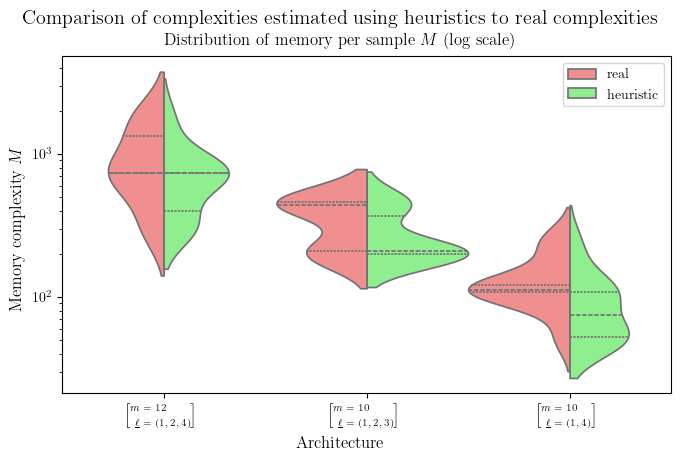

In [12]:
fig = plt.figure(figsize=(16, 8), layout="constrained")
ax = fig.subplots(1, 1)

fig.suptitle(r"\begin{center} {\Large Comparison of complexities estimated using heuristics to real complexities} \\ Distribution of memory per sample $M$ (log scale) \end{center}")
fig.supxlabel(r"Architecture")
fig.supylabel(r"Memory complexity $M$")

c_high = 1
c_low = 0.5
colours = {"real": (c_high, c_low, c_low),
           "heuristic": (c_low, c_high, c_low)}

memory_violin = \
    sns.violinplot(df,
                   x = "arch",
                   order = [str(pa) for pa in plot_architectures],
                   y = "memory",
                   hue = "probability",
                   palette=colours,
                   split = True,
                   log_scale = True,
                   inner = "quart",
                   width = 1,
                   ax = ax)

memory_violin.set(title = None, xlabel = None, ylabel = None)
memory_violin.legend(title=None)
memory_violin.set_xticks([str(pa) for pa in plot_architectures])
memory_violin.set_xticklabels([fr"${{\scriptsize\left[\begin{{aligned}} m &= {_m} \\ \vec\ell & = {_ell}\end{{aligned}}\right]}}$"
                               for _m, _ell in plot_architectures])

fig.set_size_inches(w=6.69423, h=4.5)
fig.savefig("./heuristic-validation.pdf")

# Memory complexity of power-law systems

Having validated the heuristic, in this section we use it to study large systems which cannot be simulated on current computers. Similarly to the above, we first generate data, this time only using the heuristic, without running the progressive simulator.

First, an opportunity to change the number of CPUs used and number of samples generated per architecture.
For reference, the current settings are:

In [13]:
print(f"CPUs used: {maximum_cpus}\nNumber of samples: {number_of_samples}")

CPUs used: 8
Number of samples: 10


To change these, uncomment below.

In [14]:
# maximum_cpus = None
number_of_samples = 1

if maximum_cpus is None:
    maximum_cpus = cpu_count()

print(f"CPUs used: {maximum_cpus}\nNumber of samples: {number_of_samples}")

CPUs used: 8
Number of samples: 1


To generate the samples, we run [./generate_samples_modes_lengths.sh](./generate_samples_modes_lengths.sh).

In [15]:
subprocess.call(["chmod", "u+x", "./generate_samples_modes_lengths.sh"])


log_file = "./modes-lengths-samples.log"
print(f"Starting generation of samples; scheduler log will be saved in {log_file}.\nIndividual logs will be in ./logs.\nExperiment results will be in ./experiments.")
with open(log_file, "wb") as log:
    subprocess.run(["./generate_samples_modes_lengths.sh", str(maximum_cpus), str(number_of_samples)],
                   stdout=log, stderr=log)
print("==> Done.")

Starting generation of samples; scheduler log will be saved in ./modes-lengths-samples.log. Individual logs will be in ./logs. Experiment results will be in ./experiments.
==> Done.


## Loop lengths $\underline\ell = (1, 6, 36)$ with variable number of modes $m$

As before, we load the data we generated. We again filter on the metadata of the experiments, selecting only those that have $\underline\ell=(1,6,36)$ and were generated using the heuristic (here called `paths`).

In [38]:
separate_meta_files(base_path)

data = load_experiments(
    base_path = base_path,
    filter_on_meta = lambda meta: (tuple(meta["loop_lengths"]) == (1, 6, 36)
                                    and not bool(meta["amplitudes"])
                                    and meta["progressive"]
                                    and meta["lattice_paths"]
                                    and "output_state_heuristic" in meta
                                    and meta["output_state_heuristic"] == "paths"),

    map = lambda inst: {"modes": inst["meta"]["number_modes"],
                        "fc_log": [{"fc": [np.longdouble(step["lp"])
                                            for step in component["fc@BS"]],
                                    "n<M": component["n<M"]}
                                    for component in inst["fc_log"]]},

    reduce_instances = lambda insts: pd.DataFrame([(i["modes"],
                                                    memory_complexity(i["fc_log"]))
                                                   for i in insts],
                                                  columns=["modes", "memory"]),

    reduce_experiments = lambda exprs: pd.concat(list(exprs.values())),

    tqdm_internal = False)

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

Loaded 55 out of 136 available experiments.


Compute the 95-th percentile:

In [40]:
df_percentile = pd.DataFrame([(modes,
                               data[data["modes"] == modes]["memory"].quantile(0.95))
                              for modes in pd.unique(data["modes"].values)],
                             columns=["modes", "memory_percentile95"])

Compute the memory of the OLCF-5 (Frontier) system for comparison. We assume a double-precision complex (2 reals) float representation of the amplitudes, so that the memory in bytes is $M(\underline n') \cdot (2 \cdot 8\ \mathrm B)$. We only represent the values (not the coordiante labels).

For the Frontier system, we take the assumption that all of the memory can be used to store the state amplitudes, i.e. there is no memory used to store coordinate labels, the program itself or any other programs, etc.

NB: We have made many assumptions for the sake of simplicitly. However, note that since we work in log-scale and want an approximate comparison, these assumptions do not create any issues for our results.

The plots will be presented in $M(\underline n')$ units, i.e. the dimensionless number of coordinates to store. The memory of the Frontier system in these units is `M_Frontier` below.

In [31]:
# conversion from our 
M_to_memory = 2 * 8 # two doubles
mem_Frontier = 9_408 * (512 * 2**30 + 8 * 64 * 2**30)
M_Frontier = mem_Frontier / M_to_memory

Finally, draw the figure comparing the memory requirement of simulating the $\underline\ell = (1,6,36)$ system to the number of modes $m$. This corresponds to **Fig. 10** from our paper.

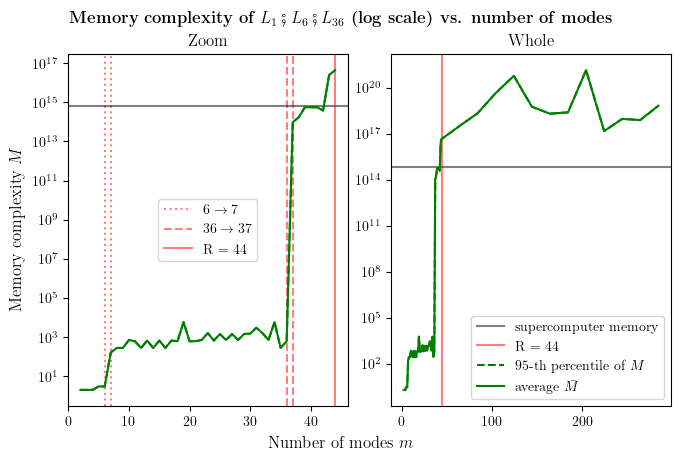

In [45]:
fig = plt.figure(figsize=(12, 8), layout="constrained")
ax = fig.subplots(1, 2, sharey=False, squeeze=True)

fig.suptitle(r"\textbf{Memory complexity of $L_1 \then L_6 \then L_{36}$ (log scale) vs. number of modes}")
fig.supylabel(r"Memory complexity $M$")
fig.supxlabel(r"Number of modes $m$")

for x, s in zip((7, 37,), ("dotted", "dashed",)):
    ax[0].axvline(x - 1, 0, 1, color="red", alpha=0.5, linestyle=s)
    ax[0].axvline(x, 0, 1, color="red", alpha=0.5, label=fr"${x-1} \to {x}$", linestyle=s)

for i in (0,1):
    ax[i].axhline(M_Frontier, 0, 1, color="black", alpha=0.5, label="supercomputer memory" if i else None)
    ax[i].axvline(44, 0, 1, color="red", alpha=0.5, label=f"R = {1+1+6+36}")

sns.lineplot(df_percentile,
             x="modes",
             y="memory_percentile95",
             ax=ax[1],
             color="g",
             linestyle="--",
             label=r"$95$-th percentile of $M$")

memplot =\
sns.lineplot(data,
             x="modes",
             y="memory",
             ax=ax[1],
             color="g",
             label=r"average $\bar M$")

memplot.set(yscale="log",
            xlabel=None,
            ylabel=None,
            title="Whole")

memplot.legend()


sns.lineplot(df_percentile[df_percentile["modes"] <= 44],
             x="modes",
             y="memory_percentile95",
             ax=ax[0],
             color="g",
             linestyle="--")

memplot_zoom =\
sns.lineplot(data[data["modes"] <= 44],
             x="modes",
             y="memory",
             ax=ax[0],
             color="g")

memplot_zoom.set(yscale="log",
                 xlabel=None,
                 ylabel=None,
                 title="Zoom")
memplot_zoom.legend()

fig.set_size_inches(w=6.69423, h=4.5)
fig.savefig("complexity-vs-modes.pdf")

## Comparison of power-law architectures

The last part of the notebook is the comparison between power-law architectures, where we allow $\ell$ to vary.

First, as usual, load the data.

In [91]:
def is_power_law(loop_lengths):
    """Helper function to check if the loop composite is a power-law system."""
    base_ell = loop_lengths[1]
    return loop_lengths[0] == 1 and all(loop_lengths[i] == base_ell**i
                                        for i in range(2, len(loop_lengths)))


data = load_experiments(base_path = base_path,
                        filter_on_meta = lambda meta: (len(meta["loop_lengths"]) == 3
                                                       and is_power_law(meta["loop_lengths"])
                                                       and not bool(meta["amplitudes"])
                                                       and meta["progressive"]
                                                       and meta["lattice_paths"]
                                                       and "output_state_heuristic" in meta
                                                       and meta["output_state_heuristic"] == "paths"),

                        map = lambda inst: {"base_ell": inst["meta"]["loop_lengths"][1],
                                            "modes": inst["meta"]["number_modes"],
                                            "fc_log": [{"fc": [np.longdouble(step["lp"])
                                                                for step in component["fc@BS"]],
                                                        "n<M": component["n<M"]}
                                                        for component in inst["fc_log"]]},

                        reduce_instances = lambda insts: pd.DataFrame([(insts[0]["modes"], insts[0]["base_ell"],
                                                                        memory_complexity(i["fc_log"]))
                                                                       for i in insts],
                                                                      columns = ["modes", "base_ell", "memory"]),

                        reduce_experiments = lambda exprs: pd.concat(list(exprs.values())),

                        tqdm_internal = False)

  0%|          | 0/136 [00:00<?, ?it/s]

Loaded 131 out of 136 available experiments.


Now, similarly to the previous section, we compute the 95-th percentiles.

In [123]:
# Pandas hack
unique_archs = data.groupby(["modes", "base_ell"]).size().reset_index()[["modes", "base_ell"]].values

df_percentile = pd.DataFrame([(modes, base_ell,
                               data[(data["modes"] == modes) & (data["base_ell"] == base_ell)]["memory"].quantile(0.95))
                              for (modes, base_ell) in unique_archs],
                             columns=["modes", "base_ell", "memory_percentile95"])

Finally, the figure comparing the memory requirement to the base loop length $\ell$ and number of modes $m$. This corresponds to **Fig. 11** in the paper.

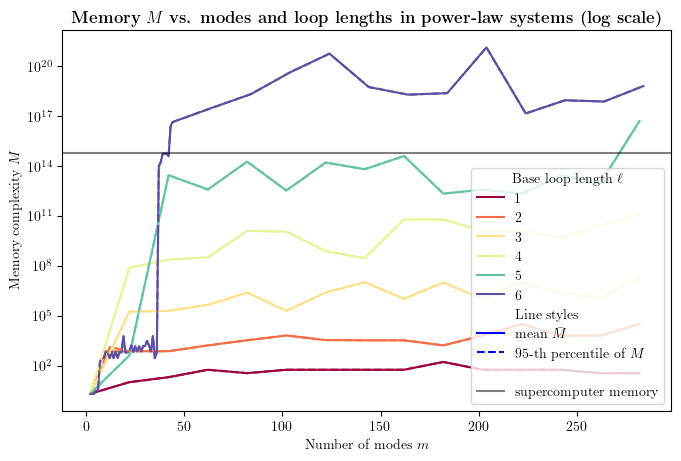

In [129]:
fig = plt.figure(figsize=(12, 6), layout="constrained")
ax = fig.subplots(1, 1, sharex=True, squeeze=False)

memplot = sns.lineplot(data,
                       x="modes",
                       y="memory",
                       hue="base_ell",
                    #    style="quantile",
                       palette="Spectral",
                       ax=ax[0, 0])

quantileplot =\
sns.lineplot(df_percentile,
             x="modes",
             y="memory_percentile95",
             hue="base_ell",
            #  style="quantile",
             palette="Spectral",
             linestyle="--",
             legend=False,
             ax=ax[0, 0],)

memplot.set_yscale("log")

ax[0,0].axhline(M_Frontier, 0, 1, color="black", alpha=0.5)

from matplotlib.lines import Line2D
handles=[*plt.gca().get_legend_handles_labels()[0],
         mpatches.Patch(color="none", label="Line styles"),
         Line2D([0], [0], color='b', label=r"mean $\bar M$"),
         Line2D([0], [0], color='b', linestyle="--", label=r"$95$-th percentile of $M$"),
         mpatches.Patch(color="none"),
         Line2D([0], [0], color="black", alpha=0.5, label="supercomputer memory")]

memplot.set_title(r"\textbf{Memory $M$ vs. modes and loop lengths in power-law systems (log scale)}")
memplot.legend(handles=handles,
               title=r"Base loop length $\ell$",
               loc="lower right",
               framealpha=0.8)

memplot.set_ylabel(r"Memory complexity $M$")
memplot.set_xlabel(r"Number of modes $m$")

fig.set_size_inches(w=6.69423, h=4.5)
fig.savefig("./power-law.pdf")